In [10]:
from alprLib.Yolo import Yolo
from alprLib.EasyOCR import Reader
import cv2
from matplotlib import pyplot as plt
import time

## Initialization

In [11]:
reader = Reader()
yolo = Yolo(weight_path='./yolo_weights/eu_dataset_256_160/yolov4-tiny_best_eudataset_downsampled.weights', config_path='./yolo_weights/eu_dataset_256_160/yolov4-tiny_downsampled.cfg')

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


Initializing EasyOCR...
EasyOCR initialized.
Initializing Yolo...
Using weights: ./yolo_weights/eu_dataset_256_160/yolov4-tiny_best_eudataset_downsampled.weights
Using config: ./yolo_weights/eu_dataset_256_160/yolov4-tiny_downsampled.cfg
Using dims: (256, 160)
Yolo initialized.


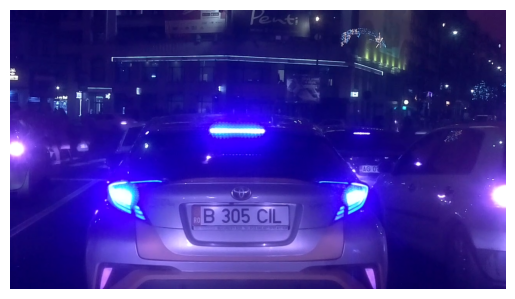

In [12]:
img = cv2.imread("./eu_dataset/images/dayride_type1_001#t=894.jpg")
plt.axis('off')
plt.imshow(img)

## Plate detection with Yolo Tiny v4

In [13]:
t0 = time.time()
bboxes = yolo.find_bboxes(img)
t1 = time.time()

print("Inference time: ", t1-t0)
bboxes

Inference time:  0.10252213478088379


[[461, 501, 258, 66], [894, 401, 69, 25]]

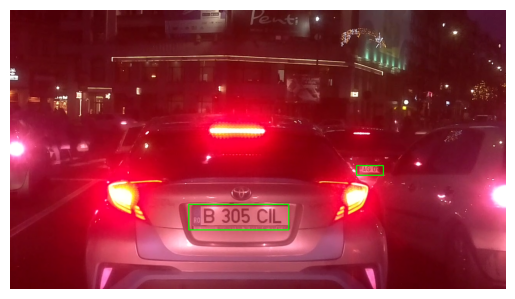

In [14]:
display_img = img.copy()

for box in bboxes:
    x, y, w, h = box
    cv2.rectangle(display_img, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(display_img[:,:,::-1])
plt.axis('off')
plt.show()

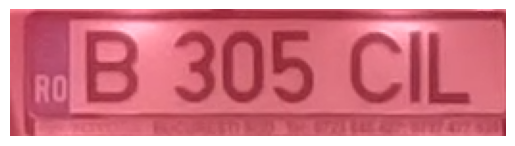

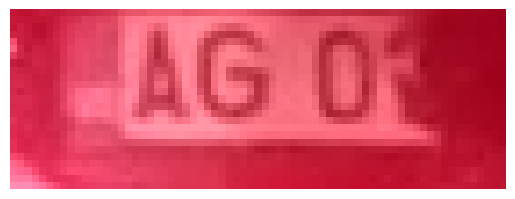

In [15]:
rois = [img[y:y+h, x:x+w] for x, y, w, h in bboxes]

# only show the license plate
for roi in rois:
    plt.imshow(roi[:,:,::-1])
    plt.axis('off')
    plt.show()

## TODO: perspective correction

## Make plate more readable

Preprocessing time:  0.0049304962158203125


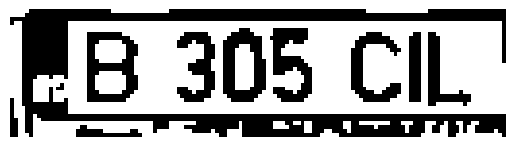

Preprocessing time:  0.0015993118286132812


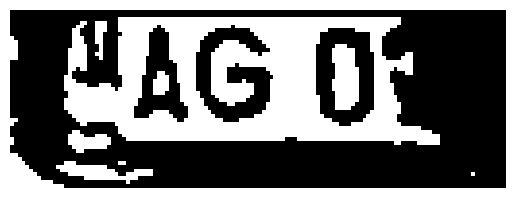

In [44]:
better_rois = []

import numpy as np

for roi in rois:
    t0 = time.time()
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    better_rois.append(gray)

    # sharpen
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    gray = cv2.filter2D(gray, -1, kernel)

    # max width is 128, but keep aspect ratio
    scale = 128 / gray.shape[1]
    gray = cv2.resize(gray, (0, 0), fx=scale, fy=scale)

    # Gaussian filter
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # threshold
    gray = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    t1 = time.time()
    print("Preprocessing time: ", t1-t0)

    plt.imshow(gray, cmap='gray')
    plt.axis('off')
    plt.show()

## OCR with EasyOCR

In [45]:
results = []

for roi in better_rois:
    t0 = time.time()
    results.append(reader.read(roi))
    t1 = time.time()

    print("Inference time: ", t1-t0)

print(results)

Inference time:  0.46619200706481934
Inference time:  0.13851451873779297
['ROB305CIL', 'AGO']
